In [1]:
import pyaudio
import wave
import speech_recognition as sr
import librosa, librosa.display
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import math
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

In [2]:
SAMPLE_RATE = 44100
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

def save_data(dataset_path, json_path, num_mfcc=13, n_fft=4096, hop_length=512, num_segments=7):
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }
    
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:

            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                for d in range(num_segments):

                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)    

In [3]:
DATASET_PATH = "./Sounds"
JSON_PATH = "data.json"
save_data(DATASET_PATH, JSON_PATH, num_segments=10)


Processing: elizabeth
./Sounds/elizabeth/eli (5).wav, segment:1
./Sounds/elizabeth/eli (5).wav, segment:2
./Sounds/elizabeth/eli (5).wav, segment:3
./Sounds/elizabeth/eli (5).wav, segment:4
./Sounds/elizabeth/eli (5).wav, segment:5
./Sounds/elizabeth/eli (5).wav, segment:6
./Sounds/elizabeth/eli (5).wav, segment:7
./Sounds/elizabeth/eli (5).wav, segment:8
./Sounds/elizabeth/eli (5).wav, segment:9
./Sounds/elizabeth/eli (5).wav, segment:10
./Sounds/elizabeth/eli (10).wav, segment:1
./Sounds/elizabeth/eli (10).wav, segment:2
./Sounds/elizabeth/eli (10).wav, segment:3
./Sounds/elizabeth/eli (10).wav, segment:4
./Sounds/elizabeth/eli (10).wav, segment:5
./Sounds/elizabeth/eli (10).wav, segment:6
./Sounds/elizabeth/eli (10).wav, segment:7
./Sounds/elizabeth/eli (10).wav, segment:8
./Sounds/elizabeth/eli (10).wav, segment:9
./Sounds/elizabeth/eli (10).wav, segment:10
./Sounds/elizabeth/eli (6).wav, segment:1
./Sounds/elizabeth/eli (6).wav, segment:2
./Sounds/elizabeth/eli (6).wav, segment:3

./Sounds/franco/franco.wav, segment:1
./Sounds/franco/franco.wav, segment:2
./Sounds/franco/franco.wav, segment:3
./Sounds/franco/franco.wav, segment:4
./Sounds/franco/franco.wav, segment:5
./Sounds/franco/franco.wav, segment:6
./Sounds/franco/franco.wav, segment:7
./Sounds/franco/franco.wav, segment:8
./Sounds/franco/franco.wav, segment:9
./Sounds/franco/franco.wav, segment:10
./Sounds/franco/franco (8).wav, segment:1
./Sounds/franco/franco (8).wav, segment:2
./Sounds/franco/franco (8).wav, segment:3
./Sounds/franco/franco (8).wav, segment:4
./Sounds/franco/franco (8).wav, segment:5
./Sounds/franco/franco (8).wav, segment:6
./Sounds/franco/franco (8).wav, segment:7
./Sounds/franco/franco (8).wav, segment:8
./Sounds/franco/franco (8).wav, segment:9
./Sounds/franco/franco (8).wav, segment:10
./Sounds/franco/franco (6).wav, segment:1
./Sounds/franco/franco (6).wav, segment:2
./Sounds/franco/franco (6).wav, segment:3
./Sounds/franco/franco (6).wav, segment:4
./Sounds/franco/franco (6).wav

In [5]:
def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [6]:
if __name__ == "__main__":
    DATA_PATH = "data.json"
    X, y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model = keras.Sequential([

        keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

        keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(3, activation='softmax')
    ])

    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)


Data succesfully loaded!
Epoch 1/100
6/6 [==============================] - 1s 35ms/step - loss: 122.8421 - accuracy: 0.4310 - val_loss: 49.7686 - val_accuracy: 0.4800
Epoch 2/100
6/6 [==============================] - 0s 20ms/step - loss: 88.3566 - accuracy: 0.4253 - val_loss: 19.7530 - val_accuracy: 0.5200
Epoch 3/100
6/6 [==============================] - 0s 18ms/step - loss: 65.3840 - accuracy: 0.3908 - val_loss: 16.9756 - val_accuracy: 0.5467
Epoch 4/100
6/6 [==============================] - 0s 17ms/step - loss: 47.5871 - accuracy: 0.4770 - val_loss: 6.7856 - val_accuracy: 0.6133
Epoch 5/100
6/6 [==============================] - 0s 21ms/step - loss: 39.8736 - accuracy: 0.4138 - val_loss: 6.8810 - val_accuracy: 0.6133
Epoch 6/100
6/6 [==============================] - 0s 20ms/step - loss: 34.5777 - accuracy: 0.4713 - val_loss: 14.2599 - val_accuracy: 0.4800
Epoch 7/100
6/6 [==============================] - 0s 20ms/step - loss: 28.5639 - accuracy: 0.5000 - val_loss: 11.7452 - val

Epoch 59/100
6/6 [==============================] - 0s 17ms/step - loss: 2.9650 - accuracy: 0.9080 - val_loss: 3.3834 - val_accuracy: 0.9600
Epoch 60/100
6/6 [==============================] - 0s 19ms/step - loss: 2.2043 - accuracy: 0.9368 - val_loss: 3.5054 - val_accuracy: 0.9600
Epoch 61/100
6/6 [==============================] - 0s 17ms/step - loss: 2.5514 - accuracy: 0.9253 - val_loss: 3.4121 - val_accuracy: 0.9600
Epoch 62/100
6/6 [==============================] - 0s 17ms/step - loss: 2.6716 - accuracy: 0.9023 - val_loss: 3.3936 - val_accuracy: 0.9600
Epoch 63/100
6/6 [==============================] - 0s 16ms/step - loss: 3.4673 - accuracy: 0.9138 - val_loss: 3.2932 - val_accuracy: 0.9600
Epoch 64/100
6/6 [==============================] - 0s 18ms/step - loss: 3.0728 - accuracy: 0.8793 - val_loss: 4.5872 - val_accuracy: 0.8667
Epoch 65/100
6/6 [==============================] - 0s 18ms/step - loss: 2.9579 - accuracy: 0.9195 - val_loss: 2.7439 - val_accuracy: 0.9600
Epoch 66/100


In [7]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)


3/3 - 0s - loss: 2.7957 - accuracy: 0.9733

Test accuracy: 0.9733333587646484


In [113]:
def grabar():
    stream=audio.open(format=FORMAT, channels=CHANNELS, rate = RATE, input=True,frames_per_buffer=CHUNK)
    print("Grabando ...")
    frames=[]

    for i in range(0,int(44100/1024*duracion)):
        data=stream.read(1024)
        frames.append(data)

    print("Grabacion a terminado ")

    stream.stop_stream()
    stream.close()
    audio.terminate()

    waveFile=wave.open(archivo,'wb')
    waveFile.setnchannels(2)
    waveFile.setsampwidth(audio.get_sample_size(pyaudio.paInt16))
    waveFile.setframerate(44100)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()

In [127]:
duracion = 2
archivo = "audio.wav"
audio=pyaudio.PyAudio()
FORMAT=pyaudio.paInt16
CHANNELS=2
RATE=44100
CHUNK=1024
grabar()

Grabando ...
Grabacion a terminado 


In [128]:
def formatFile(archivo):
    signal, sample_rate = librosa.load(archivo, sr=44100)
    mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=13, n_fft=4096, hop_length=512)
    mfcc = mfcc.T
    topredict = np.array(mfcc.tolist())
    topredict = np.expand_dims(topredict, axis=0)
    return topredict

Text(0.5, 1.0, 'Waveform')

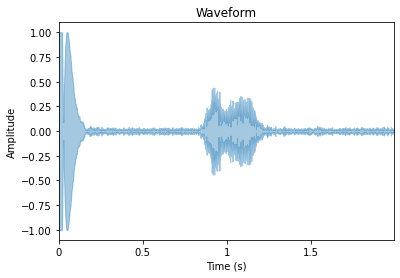

In [129]:
signal, sample_rate = librosa.load(archivo, sr=44100)
librosa.display.waveplot(signal, sample_rate, alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

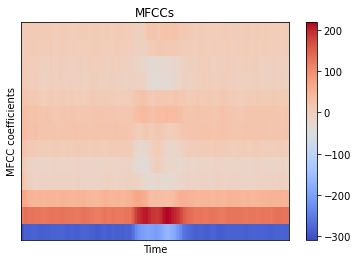

In [130]:
signal, sample_rate = librosa.load(archivo, sr=44100)

mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=13, n_fft=4096, hop_length=512)
librosa.display.specshow(mfcc, sr=sample_rate, hop_length=512)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

plt.show()

In [131]:
mfcc = mfcc.T
topredict = np.array(mfcc.tolist())
topredict = np.expand_dims(topredict, axis=0)
topredict.shape

(1, 173, 13)

In [132]:
predictions = model.predict(X_test)
user = np.argmax(predictions[2])
user

0

In [ ]:
from main import Controller
Controller(model)

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/kleber/anaconda3/lib/python3.8/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/home/kleber/Computación gráfica/main.py", line 75, in recognizer
    self.myModel.predict(self.topredict)
  File "/home/kleber/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1751, in predict
    tmp_batch_outputs = self.predict_function(iterator)
  File "/home/kleber/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 885, in __call__
    result = self._call(*args, **kwds)
  File "/home/kleber/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 933, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/home/kleber/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 759, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_c